In [49]:
%matplotlib inline
# import matplotlib.image as mpimg
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from tf_aerial_images import *
from sklearn import linear_model
from types import SimpleNamespace 
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

from preprocessing import *
from datetime import datetime
from evaluate import *
from sklearn.ensemble import RandomForestClassifier
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# remind of confusion matrix
print('Confusion matrix:')
confmat = pd.DataFrame(
    data = [['True Negative (TN)', 'False Negative (FN)'], ['False Positive (FP)', 'True Positive (TP)']],
    index = pd.MultiIndex(
        levels=[['predicted (Z)'], ['0', '1']],
        labels=[[0, 0], [0, 1]]),
    columns = pd.MultiIndex(
        levels=[['actual (Y)'], ['0 (background)', '1 (road)']],
        labels=[[0, 0], [0, 1]]),
)
display(confmat)
print('TN + FN + FP + TP = number of predictions')

Confusion matrix:


actual (Y)                     
                      0 (background)             1 (road)
predicted (Z) 0   True Negative (TN)  False Negative (FN)
              1  False Positive (FP)   True Positive (TP)

TN + FN + FP + TP = number of predictions


## 1. Load data

In [2]:
# Loaded a set of images
n = 100

imgs, gt_imgs = load_images(n)

imgs.shape, gt_imgs.shape

Loading 100 images


((400, 400, 3), (400, 400))

In [ ]:
# # Show first image and its groundtruth image
# cimg = concatenate_images(imgs[1], gt_imgs[1])
# fig1 = plt.figure(figsize=(20, 10))
# plt.imshow(cimg, cmap='Greys_r', vmin=0, vmax=1)

## 2. Transform in input and output

From each image extract the inputs (patches) and generate a list of features for each one of them.

In [9]:
set_ = SimpleNamespace()
set_.X = imgs_to_inputs(imgs)
set_.Y = imgs_to_outputs(gt_imgs)

Just check the **output** has been generated correctly.

In [79]:
# Print feature statistics
Y0 = np.where(set_.Y==0)[0]
Y1 = np.where(set_.Y==1)[0]
print(str(len(Y0)) + ' inputs are classified as background (0)')
print(str(len(Y1)) + ' inputs are classified as road (1)')

46309 inputs are classified as background (0)
16191 inputs are classified as road (1)


## 3. Train and evaluate: naive, logistic and random forest models

First, just split the dataset in test and train and tune the models a little, we will do cross-validation faterward.  

In [ ]:
train, test = split_train_test(set_.X, set_.Y, test_ratio=0.2, seed=1)

train.X.shape, train.Y.shape, test.X.shape, test.Y.shape

### a. Naive
Predict all roads

/home/niccolo/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

0 (background)       0.00      0.00      0.00     37017
      1 (road)       0.26      1.00      0.41     12983

   avg / total       0.07      0.26      0.11     50000

Confusion matrix, without normalization


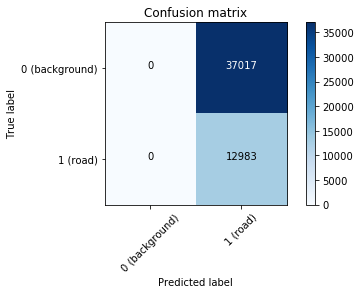

Normalized confusion matrix


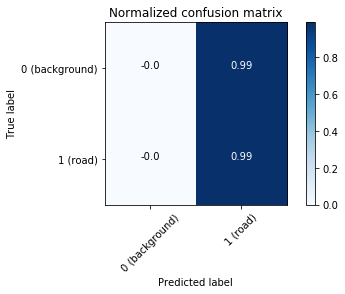

In [18]:
train.Z = np.ones(train.Y.shape)
evaluate_predictions(train.Z, train.Y)

### b. Logistic regression

                precision    recall  f1-score   support

0 (background)       0.84      0.56      0.67      9292
      1 (road)       0.35      0.69      0.46      3208

   avg / total       0.71      0.59      0.62     12500

Confusion matrix, without normalization


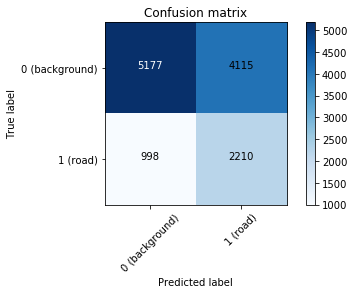

Normalized confusion matrix


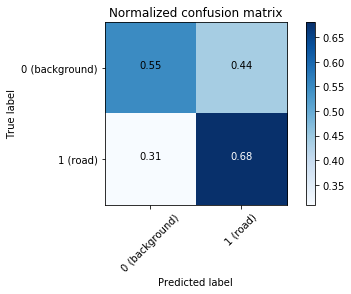

In [80]:
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced", max_iter=1000)
# train
logreg.fit(train.X, train.Y)
# predict
test.Z = logreg.predict(test.X)
# evaluate
evaluate_predictions(test.Z, test.Y)

### c. Random forest

                precision    recall  f1-score   support

0 (background)       0.82      0.92      0.87      9292
      1 (road)       0.65      0.42      0.51      3208

   avg / total       0.78      0.79      0.78     12500

Confusion matrix, without normalization


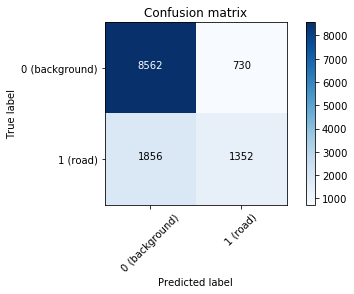

Normalized confusion matrix


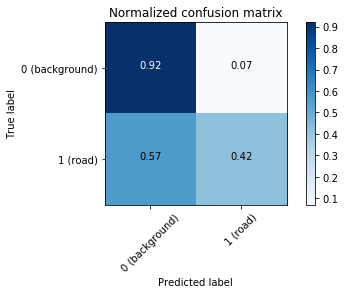

In [81]:
# train
num_estimators = 400
depth = 40
num_threads = 4
clf = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
clf.fit(train.X, train.Y)
# predict
test.Z = clf.predict(test.X)
# evaluate
evaluate_predictions(test.Z, test.Y)

## 3. Repeat with cross validation 

In [73]:
num_estimators = 500
depth = 40
num_threads = 4

def cross_validation(set_):
    # divide the data in 6 folds
    nfolds = 6

    F1_scores = {"naive": [], "logistic": [], "random_forest": []}
    kf = KFold(n_splits=nfolds)
    train = SimpleNamespace()
    test = SimpleNamespace()
    status = 1
    for train_indices, test_indices in kf.split(range(set_.X.shape[0])): # split the indices
        print("fold:", status)
        status += 1
        # split in train and test
        train.X = set_.X[train_indices]
        train.Y = set_.Y[train_indices]
        test.X = set_.X[test_indices]
        test.Y = set_.Y[test_indices]

        # fit the models
        # logistic
        print("fitting logistic")
        logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced", max_iter=1000)
        logreg.fit(train.X, train.Y)
        # random forest
        print("fitting random forest")
        rand_forest = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
        rand_forest.fit(train.X, train.Y)

        # compute F1 score of the road labels
        true = test.Y
        # naive
        f1 = f1_score(true, np.ones(true.shape), pos_label=1, average='binary', sample_weight=None)
        F1_scores["naive"].append(f1)
        # logistic
        f1 = f1_score(true, logreg.predict(test.X), pos_label=1, average='binary', sample_weight=None)
        F1_scores["logistic"].append(f1)
        # random forest
        f1 = f1_score(true, rand_forest.predict(test.X), pos_label=1, average='binary', sample_weight=None)
        F1_scores["random_forest"].append(f1)
    return F1_scores

In [ ]:
f1_scores = cross_validation(set_)

In [ ]:
# f1_scores={'logistic': [0.46514408705010168,
#   0.40765476496275366,
#   0.44973899076428858,
#   0.49714964370546316,
#   0.46313253012048183,
#   0.47467243009590704],
#  'naive': [0.41046768902113367,
#   0.36698542091236874,
#   0.40230061349693258,
#   0.45146424855061695,
#   0.4199029126213592,
#   0.41557651353818076],
#  'random_forest': [0.49617956064947466,
#   0.45909528392685273,
#   0.51150558842866534,
#   0.48005013578441619,
#   0.47865921787709503,
#   0.48172446110590439]}
f1_scores

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

bp = ax.boxplot([f1_scores["naive"], f1_scores["logistic"], f1_scores["random_forest"]], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set(color='#7570b3', linewidth=2)
    # change fill color
    box.set(facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
## Custom x-axis labels
ax.set_xticklabels(['Naive', 'Logistic regression', 'Random Forest'])
ax.set_ylabel("F1 score")
ax.set_xlabel("Models")
ax.grid()
# Save the figure
fig.savefig('boxplots.png', bbox_inches='tight')

### idea: expand features with the prediction probabilities (not much success...) .
there is something wrong (ignore this part! not worth to spend time in fixing it)

In [ ]:
X_list, Y = initialize_input_output(imgs, gt_imgs)

In [ ]:
X = np.array(flatten([flatten(matr) for matr in X_list]))
output_patches = flatten([flatten(img_crop_matr(img)) for img in gt_imgs])
Y = np.array([int(value_to_class(np.mean(patch))) for patch in output_patches])
X.shape, Y.shape

In [ ]:
models = train_models(train.imgs, train.gt_imgs, n_layers=2)

In [ ]:
Z, Y = test_models(test.imgs, test.gt_imgs, models=models)
Z.shape, Y.shape

In [ ]:
i = 1
image = test.imgs[i]
prediction = Z[i*625:(i+1)*625]
display_prediction(image, prediction)